**Packages**

In [1]:
import re
import numpy as np

import spacy

In [2]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [3]:
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import imp

tools = imp.load_source('tools', '../lda_tools.py')

**The data set**

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('../data/auction_theory_articles_meta_data.csv', index_col=0)

In [7]:
extra = pd.read_csv('../data/new_auction_data.csv', index_col=0)

In [8]:
df = pd.concat([df, extra])

//anaconda3/envs/literature/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [9]:
data = df[['abstract', 'unique_key', 'title', 'date']]

In [10]:
data = data.drop_duplicates()

In [11]:
data = data.reset_index(drop=True)

In [12]:
data.head()

,abstract,unique_key,title,date
0,The paper reports on a series of asymmetric a...,8ae35c2b42430ffc8a3b115e41e518a9,On the impact of low-balling: Experimental res...,2002.0
1,In this paper we consider the implementation...,959b0d6e5936c368cf2615c83251c470,Implementing optimal procurement auctions with...,2002.0
2,Despite growing interest in traditional and In...,78e6e08a457dc9f54b5f8bd8bd172071,Auctions: Research Opportunities in Marketing,2002.0
3,Artificial stock markets are models designed t...,7be1461bc555e207cabc2b4fd94f56e3,Testing Double Auction as a Component Within a...,2007.0
4,Amazon offers spot instances to cloud customer...,03f6ba71ff6733a6c2775719560fca99,A Survey on Spot Pricing in Cloud Computing,2018.0


In [13]:
data.describe()

,date
count,3617.000000
mean,2011.588056
std,5.407770
min,1974.000000
25%,2009.000000
50%,2013.000000
75%,2016.000000
max,2018.000000


**Sentences to words**

In [14]:
words = list(tools.sentences_to_words(data['abstract'].values))

**Cleaning data set**

In [15]:
from nltk.corpus import stopwords

In [16]:
stop_words = stopwords.words('english')

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [18]:
lemmatized_words = tools.clean_words(words, bigram, stop_words)

In [19]:
len(lemmatized_words)

3623

In [20]:
len(words)

3623

**Create corpus**

In [21]:
id2word = corpora.Dictionary(lemmatized_words)

texts = lemmatized_words

corpus = [id2word.doc2bow(text) for text in texts]

**Create model and select number of topics**

In [22]:
mallet_path = '/Users/storm/rsc/mallet-2.0.8/bin/mallet'

In [23]:
limit = 9

In [24]:
model_list, coherence_values = tools.compute_coherence_values(limit=limit,
                                                              step=1,
                                                              mallet_path=mallet_path,
                                                              dictionary=id2word,
                                                              corpus=corpus,
                                                              texts=lemmatized_words)

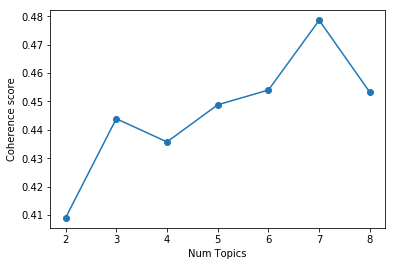

In [25]:
fig = plt.subplots()

num_of_topics = range(2, limit, 1)
plt.plot(num_of_topics, coherence_values, '-o')

plt.xlabel("Num Topics")
plt.ylabel("Coherence score");

In [26]:
for num, cv in zip(num_of_topics, coherence_values):
    print("Num Topics =", num, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4089
Num Topics = 3  has Coherence Value of 0.4439
Num Topics = 4  has Coherence Value of 0.4357
Num Topics = 5  has Coherence Value of 0.4488
Num Topics = 6  has Coherence Value of 0.454
Num Topics = 7  has Coherence Value of 0.4786
Num Topics = 8  has Coherence Value of 0.4532


In [27]:
max_coherence_value = max(coherence_values)
max_index = coherence_values.index(max_coherence_value)

In [28]:
num_of_topics[max_index]

7

**Model for num topics = 7**

In [29]:
optimal_model = model_list[max_index]
model_topics = optimal_model.show_topics(formatted=False)

**Assign Documents to Topic**

In [30]:
def format_topics_sentences(ldamodel,
                            corpus,
                            data_frame):
    data_with_topics = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                data_with_topics = data_with_topics.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4),
                                                                  topic_keywords]),
                                                         ignore_index=True)
            else:
                break
    data_with_topics.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    data_with_topics = pd.concat([data_with_topics, data_frame], axis=1)
    return data_with_topics

In [31]:
data_with_topics = format_topics_sentences(ldamodel=optimal_model,
                                           corpus=corpus,
                                           data_frame=data)

In [32]:
data_with_topics.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,abstract,unique_key,title,date
0,3.0,0.2615,"auction, price, market, bid, bidding, cost, hi...",The paper reports on a series of asymmetric a...,8ae35c2b42430ffc8a3b115e41e518a9,On the impact of low-balling: Experimental res...,2002.0
1,1.0,0.2448,"auction, mechanism, optimal, bidder, revenue, ...",In this paper we consider the implementation...,959b0d6e5936c368cf2615c83251c470,Implementing optimal procurement auctions with...,2002.0
2,0.0,0.3526,"model, economic, theory, behavior, process, ma...",Despite growing interest in traditional and In...,78e6e08a457dc9f54b5f8bd8bd172071,Auctions: Research Opportunities in Marketing,2002.0
3,0.0,0.2025,"model, economic, theory, behavior, process, ma...",Artificial stock markets are models designed t...,7be1461bc555e207cabc2b4fd94f56e3,Testing Double Auction as a Component Within a...,2007.0
4,3.0,0.2352,"auction, price, market, bid, bidding, cost, hi...",Amazon offers spot instances to cloud customer...,03f6ba71ff6733a6c2775719560fca99,A Survey on Spot Pricing in Cloud Computing,2018.0


**Find the most representative document for each topic**

In [33]:
documents_of_topic = pd.DataFrame()

documents_of_topic_grpd = data_with_topics.groupby('Dominant_Topic')

for i, grp in documents_of_topic_grpd:
    documents_of_topic = pd.concat([documents_of_topic, 
                                    grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                    axis=0)
documents_of_topic.reset_index(drop=True, inplace=True)
documents_of_topic = documents_of_topic[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords','title', 'date']]

In [34]:
documents_of_topic.values

array([[0.0, 0.5828,
        'model, economic, theory, behavior, process, make, research, information, ad, advertiser',
        '<i>Friends or Freeloaders?</i> Encouraging brand conscience and introducing the concept of emotion-based consumer loss mitigation',
        2011.0],
       [1.0, 0.5359,
        'auction, mechanism, optimal, bidder, revenue, show, buyer, good, seller, item',
        'An End-to-end Argument in Mechanism Design (Prior-independent Auctions\n  for Budgeted Agents)',
        2018.0],
       [2.0, 0.554,
        'show, study, result, number, set, function, property, win, give, simple',
        'Simple Games versus Weighted Voting Games', 2018.0],
       [3.0, 0.4604,
        'auction, price, market, bid, bidding, cost, high, paper, online, pay',
        'Setting Fees in Competing Double Auction Marketplaces: An Equilibrium Analysis',
        2012.0],
       [4.0, 0.478,
        'problem, agent, model, paper, present, approach, algorithm, solution, design, provide',

**Stats summary for each topic**

In [35]:
topic_counts = data_with_topics['Dominant_Topic'].value_counts()

topic_contribution = round(topic_counts/topic_counts.sum(), 4)

In [36]:
stats= pd.DataFrame([topic_counts.index,
                     topic_counts,
                     topic_contribution]).T
stats.columns = ['Dominant_Topic', 'Num of Documents', 'Percentage of Documents']

In [37]:
stats

,Dominant_Topic,Num of Documents,Percentage of Documents
0,6.0,708.0,0.1954
1,0.0,600.0,0.1656
2,1.0,588.0,0.1623
3,3.0,574.0,0.1584
4,5.0,509.0,0.1405
5,2.0,350.0,0.0966
6,4.0,294.0,0.0811


In [38]:
topic_num_keywords = data_with_topics[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()

df_topics = pd.merge(stats, topic_num_keywords, on='Dominant_Topic')

In [39]:
df_topics['Topic_Keywords'].values

array(['game, strategy, player, equilibrium, theory, show, play, state, nash, dynamic',
       'model, economic, theory, behavior, process, make, research, information, ad, advertiser',
       'auction, mechanism, optimal, bidder, revenue, show, buyer, good, seller, item',
       'auction, price, market, bid, bidding, cost, high, paper, online, pay',
       'base, propose, network, user, resource, allocation, system, service, performance, time',
       'show, study, result, number, set, function, property, win, give, simple',
       'problem, agent, model, paper, present, approach, algorithm, solution, design, provide'],
      dtype=object)

In [40]:
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,3.0,"auction, price, market, bid, bidding, cost, hi..."
1,1.0,"auction, mechanism, optimal, bidder, revenue, ..."
2,0.0,"model, economic, theory, behavior, process, ma..."
6,5.0,"base, propose, network, user, resource, alloca..."
23,2.0,"show, study, result, number, set, function, pr..."
37,4.0,"problem, agent, model, paper, present, approac..."
59,6.0,"game, strategy, player, equilibrium, theory, s..."


**Number of topics per year**

In [41]:
yearly = (
        data_with_topics.groupby(["Dominant_Topic", "date"]).size().reset_index().groupby("date").size()
    )

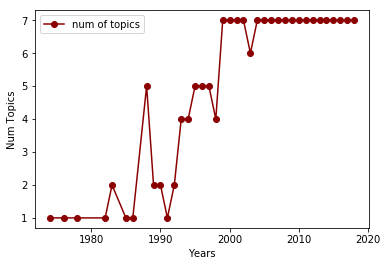

In [42]:
fig = plt.subplots()
plt.plot(yearly, '-o', color='darkred', label='num of topics');

plt.legend();
plt.ylabel("Num Topics")
plt.xlabel("Years");

**Number of articles per topic per year**

In [43]:
groups = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [44]:
selected_num_topics = num_of_topics[max_index]

In [45]:
table = data_with_topics.groupby(['date', 'Dominant_Topic']).size()

In [46]:
table

date    Dominant_Topic
1974.0  3.0                1
1976.0  0.0                1
1978.0  0.0                1
1982.0  1.0                1
1983.0  0.0                1
                          ..
2018.0  2.0               25
        3.0               42
        4.0               24
        5.0               53
        6.0               73
Length: 186, dtype: int64

In [47]:
years = sorted(data_with_topics.date.unique())

In [48]:
counts = []
for year in years:
    specific_year = data_with_topics[data_with_topics['date'] == year]
    count = []
    for topic in range(selected_num_topics):
        count.append(specific_year[specific_year["Dominant_Topic"] == topic].count().values[0])
    counts.append(count)

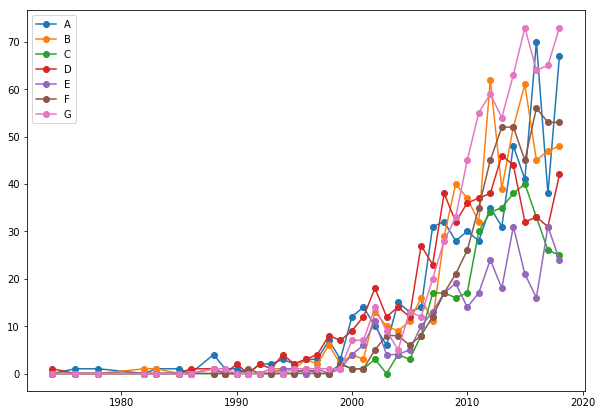

In [49]:
fig = plt.subplots(figsize=(10, 7))
for i in range(selected_num_topics):
    plt.plot(years, [c[i] for c in counts], '-o', label=f"{groups[i]}");
plt.legend();

No handles with labels found to put in legend.


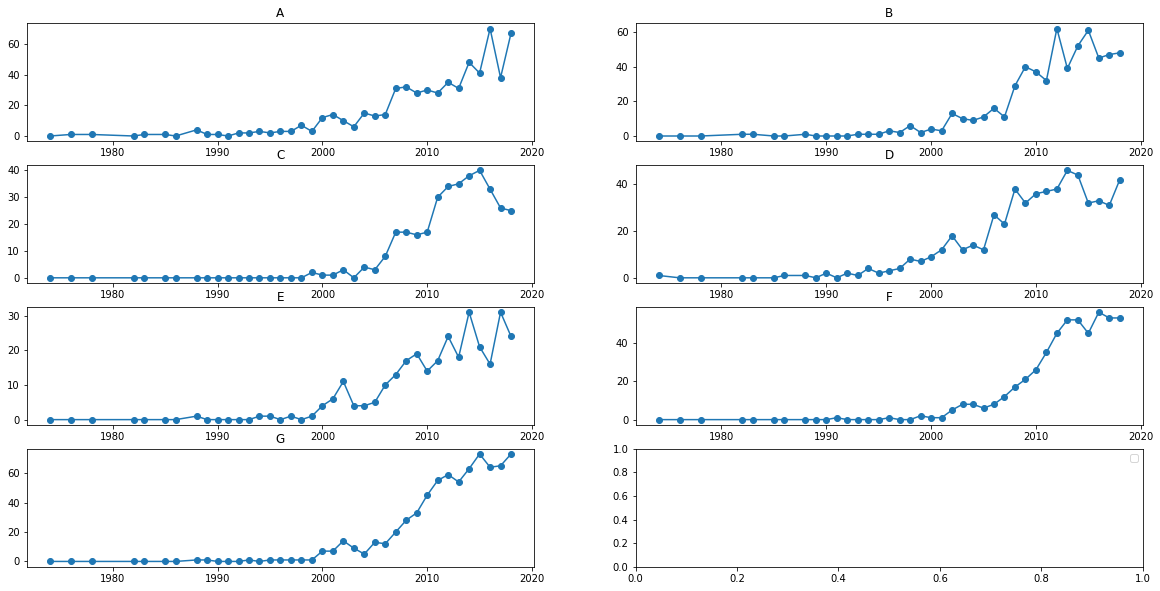

In [50]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))
for i in range(selected_num_topics):
    index = (int(i / 2), i % 2)
    axes[index].plot(years, [c[i] for c in counts], '-o',);
    axes[index].set_title(groups[i])
plt.legend();

In [51]:
subset_of_years = years[20:]

In [52]:
counts = []
for year in subset_of_years:
    specific_year = data_with_topics[data_with_topics['date'] == year]
    count = []
    for topic in range(selected_num_topics):
        count.append(specific_year[specific_year["Dominant_Topic"] == topic].count().values[0])
    counts.append(count)

No handles with labels found to put in legend.


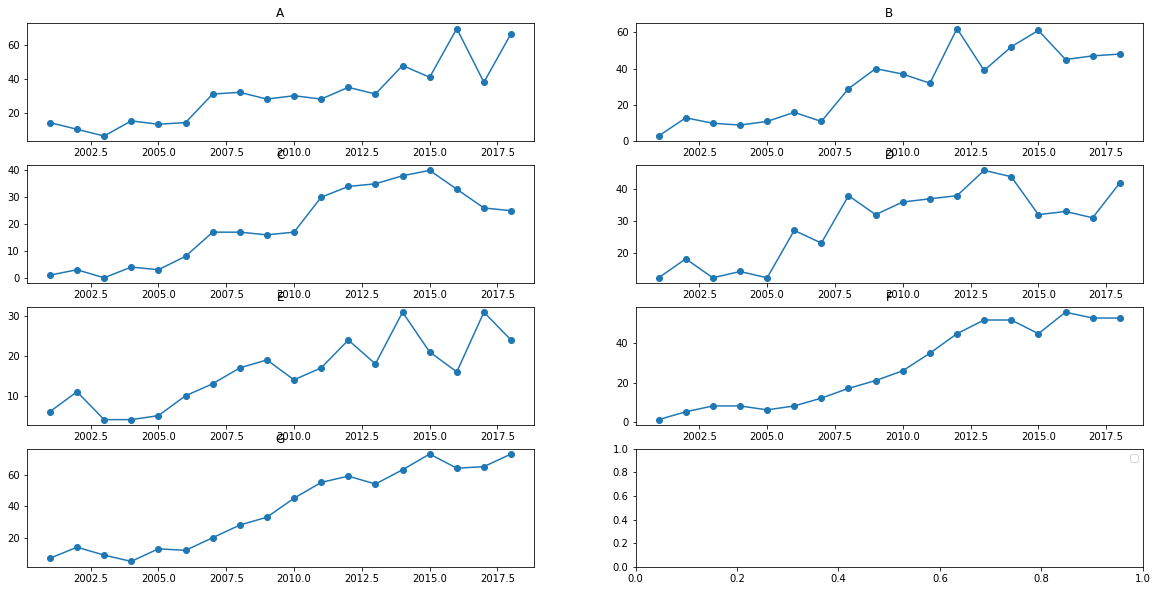

In [53]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))
for i in range(selected_num_topics):
    index = (int(i / 2), i % 2)
    axes[index].plot(subset_of_years, [c[i] for c in counts], '-o');
    axes[index].set_title(groups[i])
plt.legend();

In [54]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics[max_index], 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [55]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

//anaconda3/envs/literature/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.225211 -0.127558       1        1  32.710979
6     -0.219964 -0.117991       2        1  29.872066
1     -0.041490  0.064263       3        1  11.769258
3     -0.076718  0.201284       4        1  10.870581
4      0.088817  0.258380       5        1   5.906924
5      0.179597 -0.195814       6        1   5.756106
0      0.294968 -0.082564       7        1   3.114082, topic_info=     Category         Freq            Term        Total  loglift  logprob
394   Default  6237.000000            game  6237.000000  30.0000  30.0000
3     Default  4829.000000         auction  4829.000000  29.0000  29.0000
32    Default  2916.000000           price  2916.000000  28.0000  28.0000
170   Default  1624.000000         problem  1624.000000  27.0000  27.0000
242   Default   880.000000         network   880.000000  26.0000  26.0000
...       ...          ...             ...          ...      ...      ...
93     Topic7    65.750389          future   175.356354   2.4883  -4.7940
1187   Topic7    58.192024    relationship   124.525208   2.7085  -4.9162
1636   Topic7    56.114506  representation   147.916885   2.5000  -4.9525
91     Topic7    56.531395       empirical   169.618439   2.3705  -4.9451
474    Topic7    56.770702          effect   232.887497   2.0577  -4.9409

[374 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2807      5  0.984516  absolute
1571      5  0.981919  abstract
632       5  0.997384    access
424       1  0.997484    action
2840      6  0.987352  adoption
...     ...       ...       ...
186       3  0.347137      work
186       4  0.169025      work
186       6  0.003635      work
849       6  0.985178     world
901       6  0.990578      year

[530 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 2, 4, 5, 6, 1])